# Semantic Segmentation

*General structure following [fast.ai notebook on camvid](https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson3-camvid.ipynb)*

In [1]:
%matplotlib inline

In [2]:
from pathlib import Path
import PIL

from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

## Load Data

We use the [Berkely Deep Drive Dataset](https://bdd-data.berkeley.edu/) which contains a rich labeled dataset for image segmentation in diverse conditions (weather, city, reference car…).

In [4]:
path_data = Path('../../../../BigData/bdd100K/bdd100k/seg')
path_lbl = path_data/'labels'
path_img = path_data/'images'

In [5]:
fnames = get_image_files(path_img, recurse = True)
fnames[:3]

[PosixPath('../../../../BigData/bdd100K/bdd100k/seg/images/train/0027eed2-a6630001.jpg'),
 PosixPath('../../../../BigData/bdd100K/bdd100k/seg/images/train/a98db5bb-0b8a6e14.jpg'),
 PosixPath('../../../../BigData/bdd100K/bdd100k/seg/images/train/544f99a0-f50fd99c.jpg')]

In [6]:
lbl_names = get_image_files(path_lbl, recurse = True)
lbl_names[:3]

[PosixPath('../../../../BigData/bdd100K/bdd100k/seg/labels/train/4b2f30fd-840c8b3d_train_id.png'),
 PosixPath('../../../../BigData/bdd100K/bdd100k/seg/labels/train/0a0a0b1a-7c39d841_train_id.png'),
 PosixPath('../../../../BigData/bdd100K/bdd100k/seg/labels/train/90c9a34e-9a0830a4_train_id.png')]

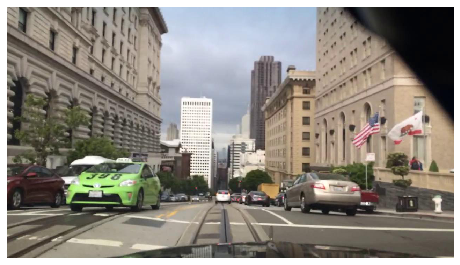

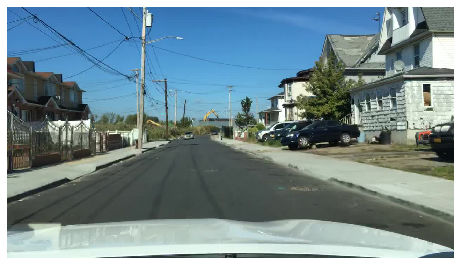

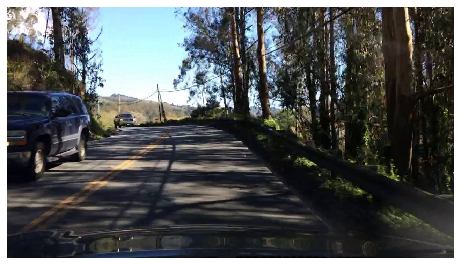

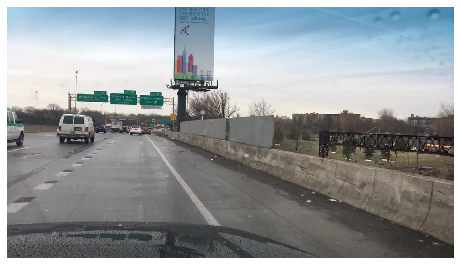

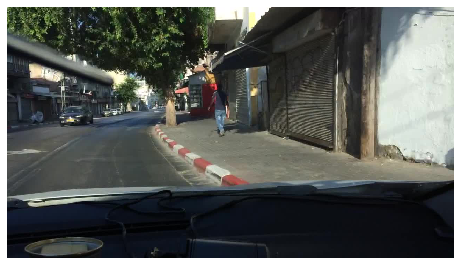

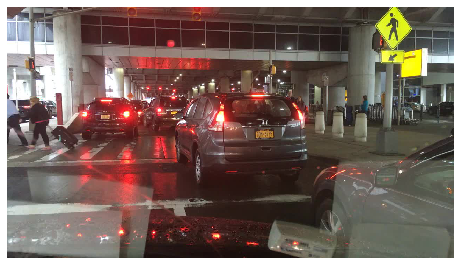

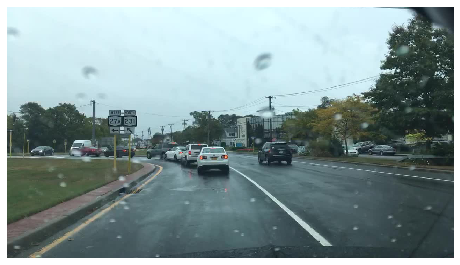

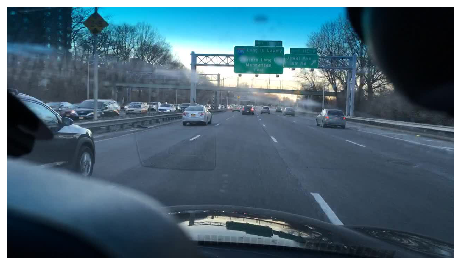

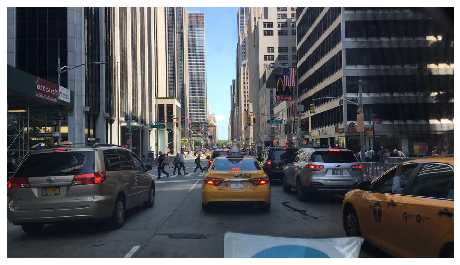

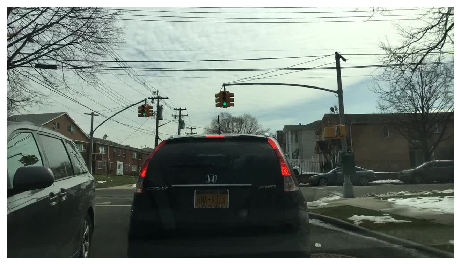

In [9]:
img_f = fnames[0]
for i in range(10):
    j = open_image(fnames[i])
#img = open_image(img_f)
#img.show(figsize=(10,10))
    j.show(figsize=(8, 8))

In [10]:
get_y_fn = lambda x: path_lbl/x.parts[-2]/f'{x.stem}_train_id.png'

img_f, get_y_fn(img_f)

(PosixPath('../../../../BigData/bdd100K/bdd100k/seg/images/train/0027eed2-a6630001.jpg'),
 PosixPath('../../../../BigData/bdd100K/bdd100k/seg/labels/train/0027eed2-a6630001_train_id.png'))

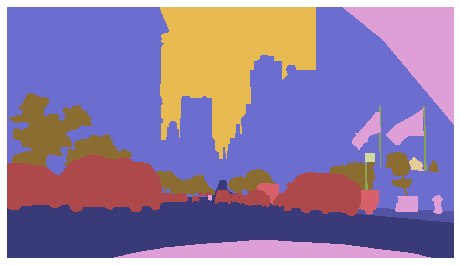

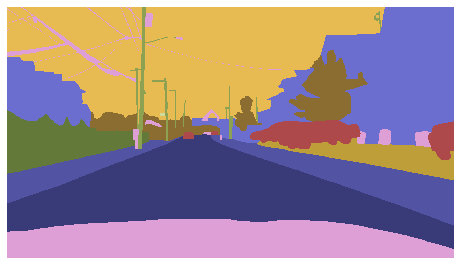

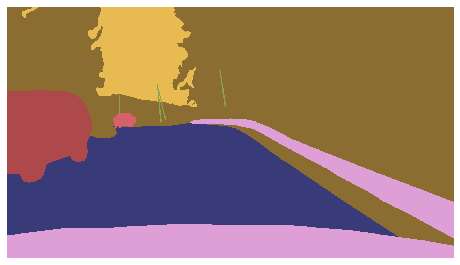

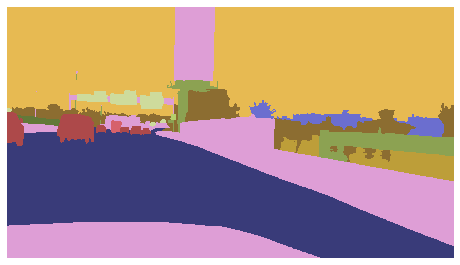

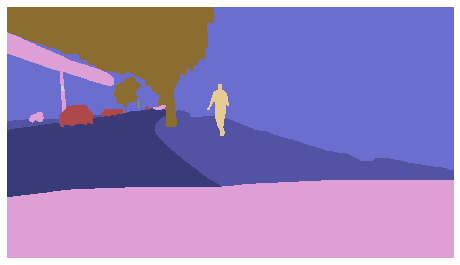

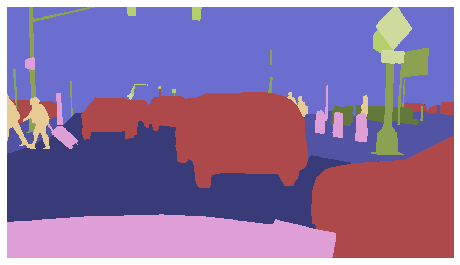

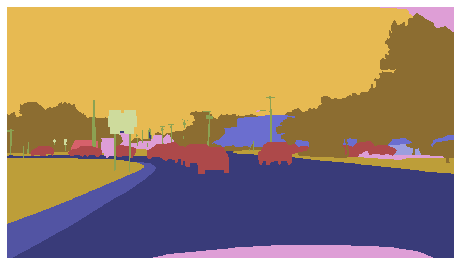

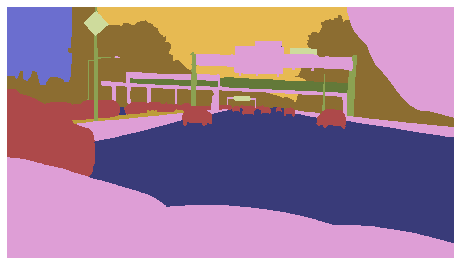

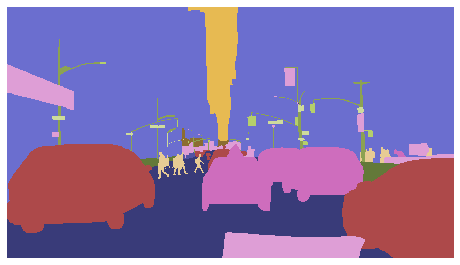

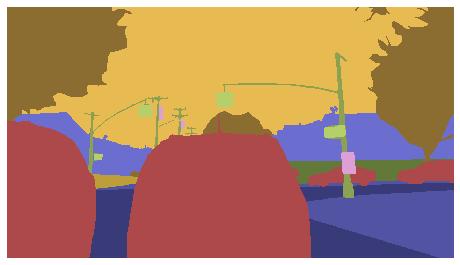

In [72]:
for i in range(10):
    mask = open_mask(get_y_fn(fnames[i]))
    mask.show(figsize=(8,8), alpha=1, cmap='tab20b')

In [9]:
src_size = np.array(mask.shape[1:])
src_size, mask.data

(array([ 720, 1280]), tensor([[[10, 10, 10,  ..., 19, 19, 19],
          [10, 10, 10,  ..., 19, 19, 19],
          [10, 10, 10,  ..., 19, 19, 19],
          ...,
          [ 0,  0,  0,  ..., 19, 19, 19],
          [ 0,  0,  0,  ..., 19, 19, 19],
          [ 0,  0,  0,  ..., 19, 19, 19]]]))

## Datasets

In [16]:
size = (180, 320)
bs = 16

In [17]:
# Classes extracted from dataset source code
# -> https://github.com/ucbdrive/bdd-data/blob/master/bdd_data/label.py

segmentation_classes = [
    'road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic light',
    'traffic sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car',
    'truck', 'bus', 'train', 'motorcycle', 'bicycle', 'void'
]
void_code = 19  # used to define accuracy and disconsider unlabeled pixels

In [18]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_folder(train='train', valid='val')
       .label_from_func(get_y_fn, classes = segmentation_classes))

In [19]:
src.train.y.loss_func

FlattenedLoss of CrossEntropyLoss()

In [20]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

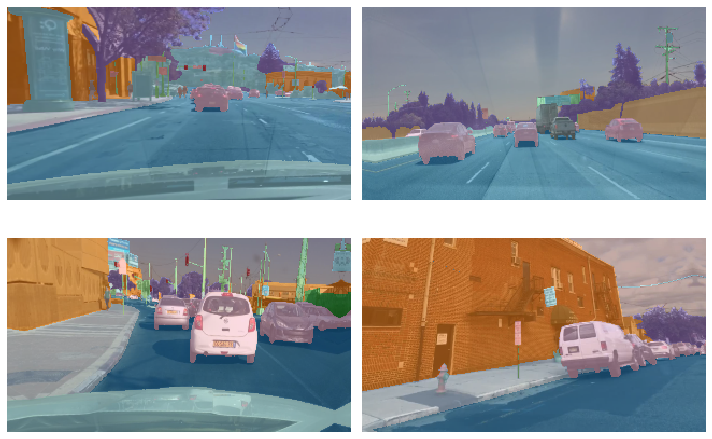

In [24]:
data.show_batch(2, figsize=(10,7))

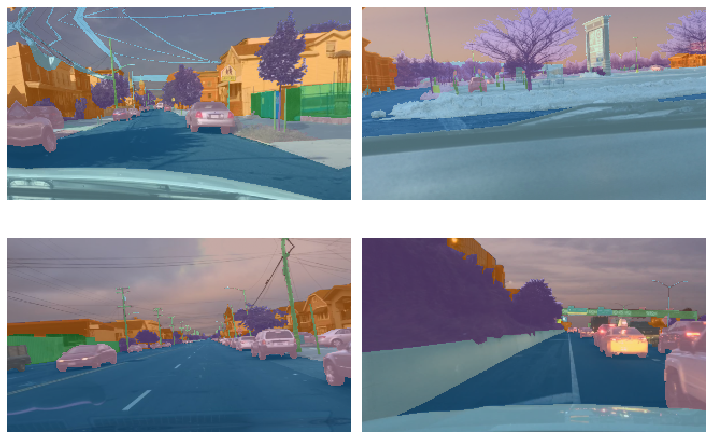

In [28]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Train)

## Model

In [29]:
def acc(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [30]:
metrics=acc

In [31]:
wd=1e-5

In [32]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/stacey/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 48.4MB/s]


epoch,train_loss,valid_loss,acc,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


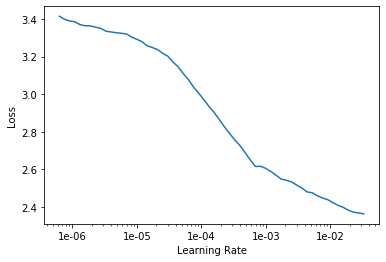

In [33]:
lr_find(learn)
learn.recorder.plot()

In [34]:
lr=3e-3

In [35]:
learn.fit_one_cycle(3, slice(lr))

epoch,train_loss,valid_loss,acc,time
0,0.874999,0.752071,0.827892,02:08
1,0.703541,0.606343,0.832506,02:06
2,0.608993,0.511844,0.861439,02:06


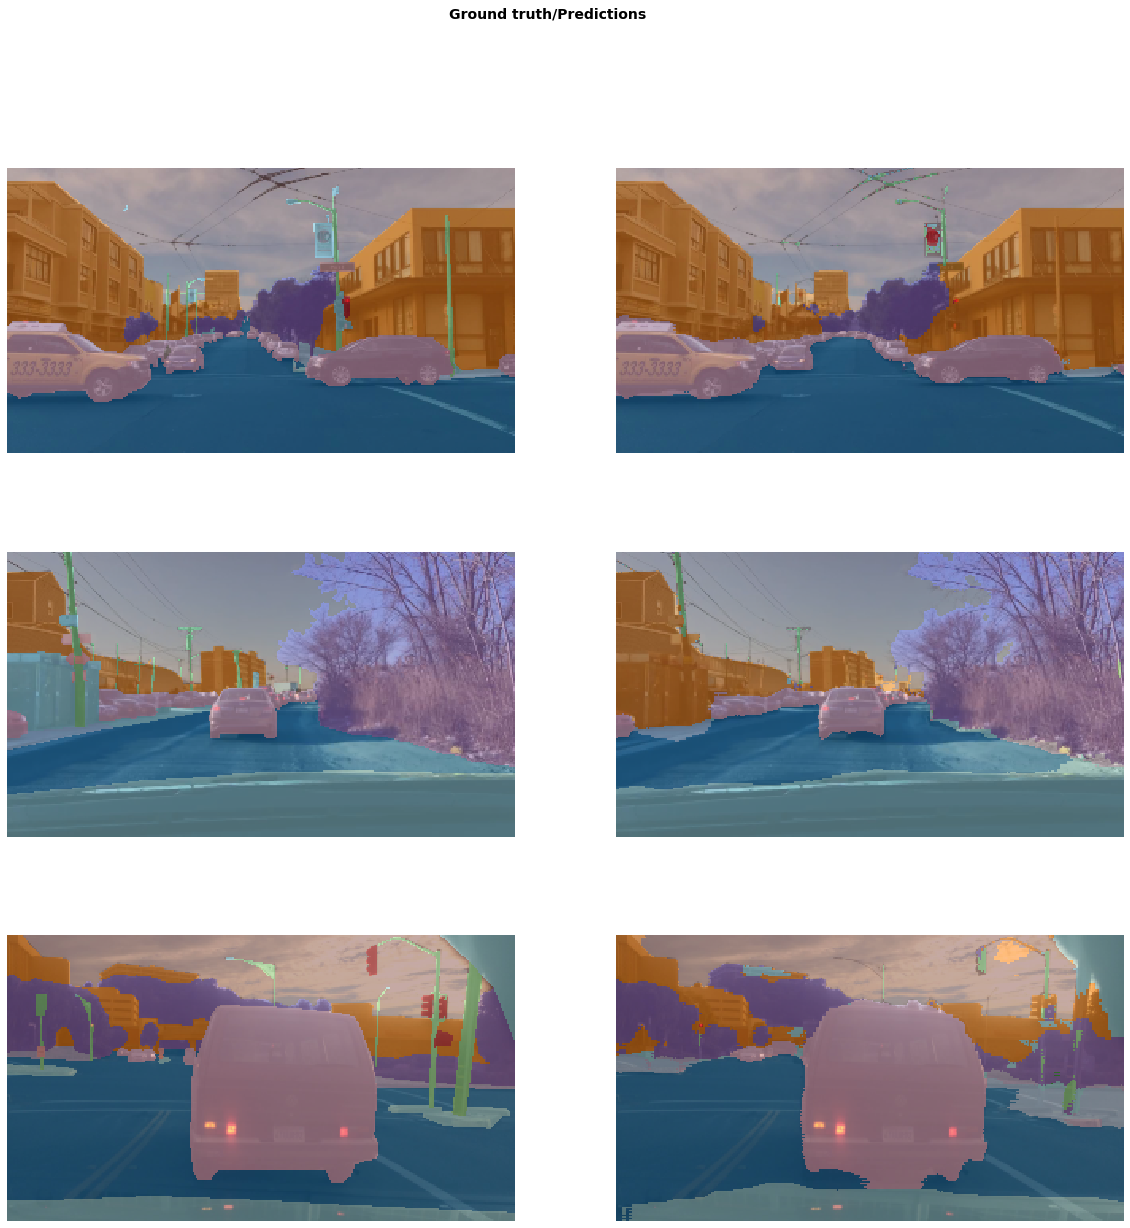

In [52]:
learn.show_results(rows=3, figsize=(20,20))

In [82]:
learn.data

AttributeError: apply_tfms

In [55]:
mask = open_mask(get_y_fn(learn.data.valid_ds[0][0]))
mask.show(figsize=(10,9), alpha=1)

AttributeError: 'Image' object has no attribute 'parts'

In [79]:
num_log = 2
input_batch = learn.data.valid_ds[:num_log]
input_batch
predictions = learn.predict(input_batch)
examples = []
for i, img in enumerate(input_batch):
    source_img = img[0]
    label = img[1]
    prediction = predictions[i]
    type(source_img)
    #label.show()
    #pred = open_image(prediction)
    #pred.show()
    

AttributeError: apply_tfms

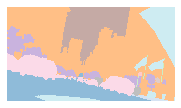

In [73]:
img = learn.data.train_ds[0][1]
img.show(cmap="tab20")

In [67]:
learn.pred_batch()

tensor([[[[1.1581e-02, 1.0156e-02, 5.3196e-03,  ..., 7.2638e-03,
           7.8942e-03, 8.2763e-03],
          [6.0029e-03, 6.9857e-03, 3.9668e-03,  ..., 6.5255e-03,
           7.2330e-03, 8.3742e-03],
          [1.7747e-03, 2.6344e-03, 3.5675e-03,  ..., 6.3160e-03,
           2.5746e-03, 3.1316e-03],
          ...,
          [8.1848e-01, 8.2330e-01, 8.5255e-01,  ..., 9.3082e-01,
           9.5091e-01, 9.4585e-01],
          [7.5879e-01, 7.6526e-01, 8.4807e-01,  ..., 9.0700e-01,
           8.9913e-01, 8.9225e-01],
          [7.4756e-01, 7.5078e-01, 8.2008e-01,  ..., 9.0872e-01,
           9.0413e-01, 8.9676e-01]],

         [[1.3986e-03, 9.4185e-04, 5.8768e-04,  ..., 9.8633e-04,
           9.6448e-04, 1.2856e-03],
          [5.1708e-04, 3.3343e-04, 2.4119e-04,  ..., 7.7629e-04,
           8.3102e-04, 1.1958e-03],
          [1.2562e-04, 9.5025e-05, 3.0222e-04,  ..., 8.3545e-04,
           4.9238e-04, 6.6444e-04],
          ...,
          [2.5210e-02, 2.6464e-02, 1.8010e-02,  ..., 1.0690

In [63]:
m = open_mask(ImageSegment(learn.predict(learn.data.valid_ds[0][0])[0]))
m.show(figsize=(10,9), alpha=1)

AttributeError: 'ImageSegment' object has no attribute 'read'

In [53]:
pred_mask = ImageMask(learn.predict((learn.data.valid_ds[0][0])[0]))
pred_mask.show()

NameError: name 'ImageMask' is not defined

Perform fine-tuning of all layers

In [ ]:
learn.unfreeze()

In [ ]:
lrs = slice(lr/400,lr/4)

In [ ]:
learn.fit_one_cycle(3, lrs, pct_start=0.5)

In [ ]:
learn.show_results(rows=3, figsize=(8,9))